## Building an ensemble of classifiers

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

notebook_num = 4

Using TensorFlow backend.
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def history_appending(history1,history2):
    history1.history['acc'] += history2.history['acc']
    history1.history['val_acc'] += history2.history['val_acc']
    history1.history['val_loss'] += history2.history['val_loss']
    history1.history['loss'] += history2.history['loss']
    return history1

def history_from_list(history_list):
    for i in range(len(history_list)-1):
        history_list[0].history['acc'] += history_list[i+1].history['acc']
        history_list[0].history['val_acc'] += history_list[i+1].history['val_acc']
        history_list[0].history['val_loss'] += history_list[i+1].history['val_loss']
        history_list[0].history['loss'] += history_list[i+1].history['loss']
    return history_list[0]
    
def to_kaggle_csv(matrix, header,filename):
    frame = pd.DataFrame(data = matrix,columns=header)
    frame.to_csv(path_or_buf  = filename,index = False,sep =',')
    return frame

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def load_train_valid_test_data(train_file,test_file,validation_percentage):
    train_data = np.genfromtxt(delimiter=',',fname=train_file,skip_header=True)
    test_data = np.genfromtxt(delimiter=',',fname=test_file,skip_header=True)
    train_y = train_data[:,0]
    train_x = train_data[:,1:]
    train_x = train_x.reshape((train_data.shape[0],28,28,1))
    enc = preprocessing.OneHotEncoder()
    enc.fit(train_y.reshape((train_y.shape[0],1)))
    train_y = enc.transform(train_y.reshape((train_y.shape[0],1))).toarray()
    train_x /= 255
    test_x = test_data.reshape((test_data.shape[0],28,28,1))
    test_x  = test_x/255
    train_x = train_x.astype('float32')
    test_x = test_x.astype('float32')
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
    
    return train_x, valid_x, test_x, train_y, valid_y

def generate_submission(model,data,filename,file_columns = None):
    predictions = model.predict(data)
    result = predictions.argmax(axis =1 )
    imgs_count = data.shape[0]
    result = result.reshape((imgs_count,1))
    ids = (np.arange(imgs_count)+1).reshape((imgs_count,1))
    result = np.hstack((ids,result))
    m = to_kaggle_csv(result,file_columns, filename)

def ensemble_submission(models,test_data,filename,file_columns = None):
    predictions = model[0].predict(data)
    for idx in range(len(models - 1)):
        predictions = predictions + model[idx+1].predict(data)
    result = predictions.argmax(axis =1)
    imgs_count = data.shape[0]
    result = result.reshape((imgs_count,1))
    ids = (np.arange(imgs_count)+1).reshape((imgs_count,1))
    result = np.hstack((ids,result))
    m = to_kaggle_csv(result,file_columns, filename)
    
def validate_preprocessing(train_x, valid_x, test_x, train_y, valid_y):
    print('max train',train_x.max())
    print('max valid',train_x.max())
    print('max test',train_x.max())
    
    print('train_x shape',train_x.shape)
    print('valid_x shape',valid_x.shape)
    print('test_x shape',test_x.shape)
    print('train_y shape',train_y.shape)
    print('valid_y shape',valid_y.shape)

In [4]:
train_x, valid_x, test_x, train_y, valid_y = load_train_valid_test_data('train.csv','test.csv',0.2)

In [5]:
validate_preprocessing(train_x, valid_x, test_x, train_y, valid_y)

max train 1.0
max valid 1.0
max test 1.0
train_x shape (33600, 28, 28, 1)
valid_x shape (8400, 28, 28, 1)
test_x shape (28000, 28, 28, 1)
train_y shape (33600, 10)
valid_y shape (8400, 10)


## Training a convolutional neural network with data augmentation
multilayer networks have the capacity to learn features of the input and build upon it in subsequent layers, so it can overfit to the training data, we'll need to make sure it doesn't, that's why we'll be monitoring the training process through both validation and training accuracies.

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras import optimizers
from keras import regularizers
from keras.layers.core import Dense, Activation# defining the layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from keras.optimizers import RMSprop, SGD , Adam
from keras.utils import np_utils
from keras import backend as K
from keras.models import clone_model
from keras.preprocessing.image import ImageDataGenerator

In [21]:
def add_conv(model,filters):
    model.add(Conv2D(filters,(3,3),padding='same'))
    model.add(Activation('relu'))
    return model
    

def CNN_architecture(Batch_Norm,dropout):
    cnn_model = Sequential()    
    cnn_model.add(Conv2D(32,(3,3),padding='same',input_shape=(28,28,1)))
    cnn_model.add(Activation('relu'))
    cnn_model = add_conv(cnn_model,32)
    cnn_model.add(MaxPooling2D(pool_size =(2,2),strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    cnn_model = add_conv(cnn_model,64)
    cnn_model = add_conv(cnn_model,64)
    cnn_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64))
    cnn_model.add(Activation('relu'))
    if Batch_Norm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(drop_out))
    cnn_model.add(Dense(32))
    cnn_model.add(Activation('relu'))
    if Batch_Norm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(drop_out))
    cnn_model.add(Dense(10))
    cnn_model.add(Activation('softmax'))
    return cnn_model

def CNN_model_augmentation(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None, Batch_Norm = True,drop_out = 0.5):
    cnn_model = CNN_architecture(Batch_Norm,drop_out)
    datagen = ImageDataGenerator( rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
        zoom_range=0.2, fill_mode='nearest')
    batch_size = 64
    train_generator = datagen.flow(train_x,train_y,batch_size = 64)
    steps_per_epoch = int(train_x.shape[0]/batch_size)
    optimizer = Adam(lr= 0.001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    optimizer = Adam(lr= 0.0001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    optimizer = Adam(lr= 0.00001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    
    return cnn_model,history

In [14]:
drop_outs = [0,0.35]
models = []
histories = []
optimizer = 'adam'
n_epochs = 2
for drop_out in drop_outs:
    history,model = CNN_model_augmentation(optimizer,n_epochs, train_x, train_y, valid_x, valid_y,drop_out = drop_out)
    #print("Batch Normalization: ", batch)
    #print("Technique ", technique_dict[tech])
    #print("drop_out ", drop_out)
    models.append(model)
    histories.append(history)

Epoch 1/1
525/525 [==============================] - 19s 37ms/step - loss: 0.4820 - acc: 0.8567 - val_loss: 0.0776 - val_acc: 0.9771
Epoch 1/1
525/525 [==============================] - 19s 36ms/step - loss: 0.1458 - acc: 0.9566 - val_loss: 0.0404 - val_acc: 0.9883
Epoch 1/1
525/525 [==============================] - 20s 37ms/step - loss: 0.1238 - acc: 0.9634 - val_loss: 0.0365 - val_acc: 0.9905
Epoch 1/1
525/525 [==============================] - 20s 38ms/step - loss: 1.0550 - acc: 0.6669 - val_loss: 0.1077 - val_acc: 0.9718
Epoch 1/1
525/525 [==============================] - 20s 38ms/step - loss: 0.3742 - acc: 0.8955 - val_loss: 0.0711 - val_acc: 0.9808
Epoch 1/1
525/525 [==============================] - 20s 39ms/step - loss: 0.3334 - acc: 0.9091 - val_loss: 0.0654 - val_acc: 0.9824


## Building an ensemble of classifiers

In [39]:
def CNN_model_3(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None, Batch_Norm = False,drop_out = 0.5):
    cnn_model = CNN_architecture(Batch_Norm,drop_out)
    history_list = []
    for i in range(3):
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 64,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 128,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
    return cnn_model, history_from_list(history_list)

def CNN_ensemble_models(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None, Batch_Norm = False,drop_out = 0.5):
    cnn_model = CNN_architecture(Batch_Norm,drop_out)
    history_list = []
    for i in range(3):
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 64,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 128,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
        models.append(clone_model(cnn_model))
    return models,history_list

In [ ]:
drop_outs = [0.45,0.4,0.5,0.55]
ensemble_models = []
ensemble_histories = []
optimizer = 'adam'
n_epochs = 40
for drop_out in drop_outs:
    print("starting")
    print("");print("")
    model,history = CNN_model_3(optimizer,n_epochs, train_x, train_y, valid_x, valid_y,drop_out = drop_out)
    #print("Batch Normalization: ", batch)
    #print("Technique ", technique_dict[tech])
    #print("drop_out ", drop_out)
    ensemble_models.append(model)
    ensemble_histories.append(history)

starting


Train on 33600 samples, validate on 8400 samples
Epoch 1/26
33600/33600 [==============================] - 16s 463us/step - loss: 0.7856 - acc: 0.7391 - val_loss: 0.1012 - val_acc: 0.9725
Epoch 2/26
33600/33600 [==============================] - 10s 284us/step - loss: 0.3219 - acc: 0.9038 - val_loss: 0.0795 - val_acc: 0.9789
Epoch 3/26
33600/33600 [==============================] - 10s 284us/step - loss: 0.2373 - acc: 0.9296 - val_loss: 0.0606 - val_acc: 0.9855
Epoch 4/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.1946 - acc: 0.9429 - val_loss: 0.0622 - val_acc: 0.9848
Epoch 5/26
33600/33600 [==============================] - 10s 286us/step - loss: 0.1723 - acc: 0.9505 - val_loss: 0.0556 - val_acc: 0.9864
Epoch 6/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.1633 - acc: 0.9536 - val_loss: 0.0488 - val_acc: 0.9880
Epoch 7/26
33600/33600 [==============================] - 10s 284us/step - loss: 0.1419 - acc: 0.9598 - va

Epoch 7/26
33600/33600 [==============================] - 10s 286us/step - loss: 0.0541 - acc: 0.9837 - val_loss: 0.0436 - val_acc: 0.9923
Epoch 8/26
33600/33600 [==============================] - 10s 284us/step - loss: 0.0544 - acc: 0.9829 - val_loss: 0.0407 - val_acc: 0.9926
Epoch 9/26
33600/33600 [==============================] - 10s 288us/step - loss: 0.0495 - acc: 0.9848 - val_loss: 0.0391 - val_acc: 0.9927
Epoch 10/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.0617 - acc: 0.9824 - val_loss: 0.0470 - val_acc: 0.9907
Epoch 11/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.0546 - acc: 0.9840 - val_loss: 0.0377 - val_acc: 0.9923
Epoch 12/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.0509 - acc: 0.9841 - val_loss: 0.0350 - val_acc: 0.9933
Epoch 13/26
33600/33600 [==============================] - 10s 285us/step - loss: 0.0504 - acc: 0.9847 - val_loss: 0.0350 - val_acc: 0.9927
Epoch 14/26
33600/33600

33600/33600 [==============================] - 10s 291us/step - loss: 0.0509 - acc: 0.9857 - val_loss: 0.0349 - val_acc: 0.9927
Epoch 20/26
33600/33600 [==============================] - 10s 289us/step - loss: 0.0552 - acc: 0.9845 - val_loss: 0.0362 - val_acc: 0.9918
Epoch 21/26
33600/33600 [==============================] - 10s 287us/step - loss: 0.0495 - acc: 0.9852 - val_loss: 0.0358 - val_acc: 0.9915
Epoch 22/26
33600/33600 [==============================] - 10s 289us/step - loss: 0.0455 - acc: 0.9867 - val_loss: 0.0329 - val_acc: 0.9921
Epoch 23/26
33600/33600 [==============================] - 10s 291us/step - loss: 0.0462 - acc: 0.9868 - val_loss: 0.0377 - val_acc: 0.9911
Epoch 24/26
33600/33600 [==============================] - 10s 288us/step - loss: 0.0443 - acc: 0.9868 - val_loss: 0.0307 - val_acc: 0.9925
Epoch 25/26
33600/33600 [==============================] - 10s 297us/step - loss: 0.0432 - acc: 0.9878 - val_loss: 0.0385 - val_acc: 0.9929
Epoch 26/26
33600/33600 [=======

Epoch 5/26
33600/33600 [==============================] - 8s 229us/step - loss: 0.0184 - acc: 0.9945 - val_loss: 0.0459 - val_acc: 0.9944
Epoch 6/26
33600/33600 [==============================] - 8s 235us/step - loss: 0.0152 - acc: 0.9954 - val_loss: 0.0478 - val_acc: 0.9945
Epoch 7/26
33600/33600 [==============================] - 8s 237us/step - loss: 0.0150 - acc: 0.9956 - val_loss: 0.0466 - val_acc: 0.9945
Epoch 8/26
33600/33600 [==============================] - 8s 239us/step - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0484 - val_acc: 0.9944
Epoch 9/26
33600/33600 [==============================] - 8s 237us/step - loss: 0.0136 - acc: 0.9958 - val_loss: 0.0469 - val_acc: 0.9942
Epoch 10/26
33600/33600 [==============================] - 8s 234us/step - loss: 0.0136 - acc: 0.9962 - val_loss: 0.0464 - val_acc: 0.9944
Epoch 11/26
33600/33600 [==============================] - 8s 235us/step - loss: 0.0144 - acc: 0.9951 - val_loss: 0.0479 - val_acc: 0.9945
Epoch 12/26
33600/33600 [=======

33600/33600 [==============================] - 8s 225us/step - loss: 0.0769 - acc: 0.9729 - val_loss: 0.0380 - val_acc: 0.9950
Epoch 18/26
30336/33600 [==========================>...] - ETA: 0s - loss: 0.0812 - acc: 0.9712

In [38]:
val_acc_list = []
for history in ensemble_histories:
    
    print(history.history['val_acc'][-1])
    val_acc_list.append(history.history['acc'])
val_acc_np = np.array(val_acc_list)
arg = np.argmax(val_acc_np,axis = 0)[-1]
print (arg,val_acc_np[3,-1])
models[3].summary()

0.994642857256
0.99297619059
0.99416666678
0.992857142971
1 0.962291666667


IndexError: list index out of range

In [77]:
generate_submission(models[-2],test_x,'sub_adam_cnn_2c_1p_2c_1p_train9965_valid9962_batch_lrannealing.csv',['ImageId','Label'])

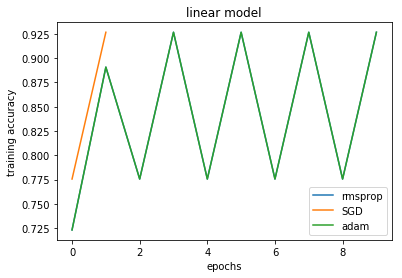

0.926517857143 0.842172619048


In [33]:
plt.figure()

hist1 = ensemble_models[0].history['acc']
hist2 = ensemble_models[1].history['acc']
h = history_appending(ensemble_models[0],ensemble_models[1])
hist3 = ensemble_models[2].history['acc']
plt.title('linear model')
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.plot(hist1,label='rmsprop')
plt.plot(hist2,label='SGD')
plt.plot(h.history['acc'],label='adam')
plt.legend()
plt.show()
print(hist1[-1],hist3[-1])

In [139]:
predictions.shape
result = predictions.argmax(axis =1 )
result.shape
result = result.reshape((28000,1))
ids = (np.arange(28000)+1).reshape((28000,1))
result = np.hstack((ids,result))
print(result[:4,:],result.shape)
m = to_kaggle_csv(result,['ImageId','Label'],'submission_adam_model_300ep_no_regularization.csv')
print(m.head())
#plt.imshow(test_x[3,:].reshape((28,28)))
#plt.show()

[1 2 3 4]
[[1 2]
 [2 0]
 [3 9]
 [4 7]] (28000, 2)
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      7
4        5      3


### Summary for the linear model
####  The output of the linear model
the submission got the 1653th place out of 1879, this is the top 87.9% with accuracy of 91.6%, which is really bad for mnist dataset, as it's the easiest task you'll ever workon and it's far below our human level accuracy.
Note that training accuracy is around 94.4% and the submission accuracy is around 91.6%.
We've been training for around 270 epochs
<img src="1-linearmodel.PNG" height="300" width = "800" >

## Linear models with regularization

now the model is overfitting --> training acc is 94.4 and submission accuracy is 91.6.
Next step is to add regularization and reduce overfitting --> thus we need a separate validation set to monitor overfitting.
We'll find that a linear model isn't capable of overfitting and any further regularization will only reduce the training error, as the model doesn't have the capacity to overfit

That's why it's a best practice in neural networks to overfit the data first to make sure that your model is good, then add regularization to generalize better, but you shouldn't spend anytime trying to prevent overfitting using a model with high bias (simple models).

In [151]:
from sklearn.model_selection import train_test_split
## validation set
y = train_data[:,0]
X = train_data[:,1:]
enc = preprocessing.OneHotEncoder()
enc.fit(y.reshape((y.shape[0],1)))
train_y = enc.transform(y.reshape((y.shape[0],1))).toarray()

train_x, valid_x, train_y, valid_y = train_test_split(X, train_y, test_size=0.2, random_state=42)

In [165]:
regs = [0.1,0.01,0.001,0.0001,0]
models = []
optimizer = 'rmsprop'
histories = []
for reg in regs:
    model,history = linear_model(optimizer,150, train_x,train_y,regularization=reg,valid_x=valid_x,valid_y=valid_y)
    models.append(model)
    histories.append(history)

Train on 33600 samples, validate on 8400 samples
Epoch 1/150
33600/33600 [==============================] - 4s 107us/step - loss: 1.5293 - acc: 0.8036 - val_loss: 1.3471 - val_acc: 0.8408
Epoch 2/150
33600/33600 [==============================] - 3s 86us/step - loss: 1.3466 - acc: 0.8391 - val_loss: 1.3412 - val_acc: 0.8390
Epoch 3/150
33600/33600 [==============================] - 3s 86us/step - loss: 1.3423 - acc: 0.8398 - val_loss: 1.3424 - val_acc: 0.8383
Epoch 4/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3394 - acc: 0.8385 - val_loss: 1.3337 - val_acc: 0.8396
Epoch 5/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3376 - acc: 0.8388 - val_loss: 1.3358 - val_acc: 0.8371
Epoch 6/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3364 - acc: 0.8385 - val_loss: 1.3352 - val_acc: 0.8418
Epoch 7/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3351 - acc: 0.8392 - val_loss: 1.3383 - 

Epoch 118/150
33600/33600 [==============================] - 3s 89us/step - loss: 1.3326 - acc: 0.8363 - val_loss: 1.3314 - val_acc: 0.8404
Epoch 119/150
33600/33600 [==============================] - 3s 90us/step - loss: 1.3337 - acc: 0.8361 - val_loss: 1.3327 - val_acc: 0.8371
Epoch 120/150
33600/33600 [==============================] - 3s 92us/step - loss: 1.3330 - acc: 0.8361 - val_loss: 1.3306 - val_acc: 0.8437
Epoch 121/150
33600/33600 [==============================] - 3s 90us/step - loss: 1.3332 - acc: 0.8365 - val_loss: 1.3299 - val_acc: 0.8361
Epoch 122/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3330 - acc: 0.8366 - val_loss: 1.3323 - val_acc: 0.8321
Epoch 123/150
33600/33600 [==============================] - 3s 85us/step - loss: 1.3333 - acc: 0.8381 - val_loss: 1.3316 - val_acc: 0.8438
Epoch 124/150
33600/33600 [==============================] - 3s 87us/step - loss: 1.3329 - acc: 0.8381 - val_loss: 1.3328 - val_acc: 0.8383
Epoch 125/150
33600/

33600/33600 [==============================] - 3s 86us/step - loss: 0.6653 - acc: 0.8905 - val_loss: 0.6684 - val_acc: 0.8850
Epoch 86/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.6654 - acc: 0.8897 - val_loss: 0.6715 - val_acc: 0.8860
Epoch 87/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.6656 - acc: 0.8898 - val_loss: 0.6701 - val_acc: 0.8871
Epoch 88/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.6652 - acc: 0.8899 - val_loss: 0.6712 - val_acc: 0.8862
Epoch 89/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.6653 - acc: 0.8900 - val_loss: 0.6729 - val_acc: 0.8867
Epoch 90/150
33600/33600 [==============================] - 3s 85us/step - loss: 0.6653 - acc: 0.8908 - val_loss: 0.6699 - val_acc: 0.8874
Epoch 91/150
33600/33600 [==============================] - 3s 83us/step - loss: 0.6655 - acc: 0.8901 - val_loss: 0.6718 - val_acc: 0.8862
Epoch 92/150
33600/33600 [==============

Epoch 144/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.6656 - acc: 0.8895 - val_loss: 0.6725 - val_acc: 0.8817
Epoch 145/150
33600/33600 [==============================] - 3s 89us/step - loss: 0.6657 - acc: 0.8900 - val_loss: 0.6707 - val_acc: 0.8831
Epoch 146/150
33600/33600 [==============================] - 3s 88us/step - loss: 0.6653 - acc: 0.8900 - val_loss: 0.6692 - val_acc: 0.8885
Epoch 147/150
33600/33600 [==============================] - 3s 91us/step - loss: 0.6654 - acc: 0.8901 - val_loss: 0.6709 - val_acc: 0.8880
Epoch 148/150
33600/33600 [==============================] - 3s 89us/step - loss: 0.6648 - acc: 0.8896 - val_loss: 0.6720 - val_acc: 0.8875
Epoch 149/150
33600/33600 [==============================] - 3s 86us/step - loss: 0.6652 - acc: 0.8896 - val_loss: 0.6730 - val_acc: 0.8875
Epoch 150/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.6658 - acc: 0.8893 - val_loss: 0.6698 - val_acc: 0.8875
Train on 33600 sampl

Epoch 111/150
33600/33600 [==============================] - 3s 88us/step - loss: 0.3869 - acc: 0.9161 - val_loss: 0.4075 - val_acc: 0.9065
Epoch 112/150
33600/33600 [==============================] - 3s 85us/step - loss: 0.3869 - acc: 0.9160 - val_loss: 0.4049 - val_acc: 0.9107
Epoch 113/150
33600/33600 [==============================] - 3s 86us/step - loss: 0.3865 - acc: 0.9167 - val_loss: 0.4045 - val_acc: 0.9119
Epoch 114/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.3868 - acc: 0.9164 - val_loss: 0.4080 - val_acc: 0.9065
Epoch 115/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.3869 - acc: 0.9153 - val_loss: 0.4049 - val_acc: 0.9101
Epoch 116/150
33600/33600 [==============================] - 3s 85us/step - loss: 0.3870 - acc: 0.9160 - val_loss: 0.4074 - val_acc: 0.9088
Epoch 117/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.3869 - acc: 0.9162 - val_loss: 0.4047 - val_acc: 0.9095
Epoch 118/150
33600/

33600/33600 [==============================] - 3s 88us/step - loss: 0.3126 - acc: 0.9303 - val_loss: 0.3558 - val_acc: 0.9175
Epoch 79/150
33600/33600 [==============================] - 3s 83us/step - loss: 0.3128 - acc: 0.9300 - val_loss: 0.3572 - val_acc: 0.9190
Epoch 80/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.3128 - acc: 0.9308 - val_loss: 0.3567 - val_acc: 0.9180
Epoch 81/150
33600/33600 [==============================] - 3s 85us/step - loss: 0.3130 - acc: 0.9305 - val_loss: 0.3562 - val_acc: 0.9185
Epoch 82/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.3134 - acc: 0.9306 - val_loss: 0.3568 - val_acc: 0.9175
Epoch 83/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.3140 - acc: 0.9305 - val_loss: 0.3573 - val_acc: 0.9194
Epoch 84/150
33600/33600 [==============================] - 3s 83us/step - loss: 0.3137 - acc: 0.9310 - val_loss: 0.3602 - val_acc: 0.9173
Epoch 85/150
33600/33600 [==============

Epoch 137/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.3262 - acc: 0.9307 - val_loss: 0.3689 - val_acc: 0.9186
Epoch 138/150
33600/33600 [==============================] - 3s 90us/step - loss: 0.3258 - acc: 0.9304 - val_loss: 0.3692 - val_acc: 0.9194
Epoch 139/150
33600/33600 [==============================] - 3s 94us/step - loss: 0.3265 - acc: 0.9310 - val_loss: 0.3690 - val_acc: 0.9182
Epoch 140/150
33600/33600 [==============================] - 3s 99us/step - loss: 0.3266 - acc: 0.9309 - val_loss: 0.3719 - val_acc: 0.9174
Epoch 141/150
33600/33600 [==============================] - 3s 99us/step - loss: 0.3269 - acc: 0.9307 - val_loss: 0.3718 - val_acc: 0.9175
Epoch 142/150
33600/33600 [==============================] - 3s 91us/step - loss: 0.3263 - acc: 0.9318 - val_loss: 0.3712 - val_acc: 0.9175
Epoch 143/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.3272 - acc: 0.9309 - val_loss: 0.3708 - val_acc: 0.9187
Epoch 144/150
33600/

33600/33600 [==============================] - 3s 85us/step - loss: 0.2276 - acc: 0.9424 - val_loss: 0.3251 - val_acc: 0.9198
Epoch 105/150
33600/33600 [==============================] - 3s 85us/step - loss: 0.2275 - acc: 0.9429 - val_loss: 0.3244 - val_acc: 0.9199
Epoch 106/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.2270 - acc: 0.9424 - val_loss: 0.3254 - val_acc: 0.9215
Epoch 107/150
33600/33600 [==============================] - 3s 87us/step - loss: 0.2270 - acc: 0.9422 - val_loss: 0.3254 - val_acc: 0.9199
Epoch 108/150
33600/33600 [==============================] - 3s 86us/step - loss: 0.2270 - acc: 0.9436 - val_loss: 0.3269 - val_acc: 0.9201
Epoch 109/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.2272 - acc: 0.9428 - val_loss: 0.3254 - val_acc: 0.9199
Epoch 110/150
33600/33600 [==============================] - 3s 84us/step - loss: 0.2267 - acc: 0.9432 - val_loss: 0.3272 - val_acc: 0.9212
Epoch 111/150
33600/33600 [=======

In [169]:
print('regularizaiton','training acc','validation acc')
for idx, histor in enumerate(histories):
    tr_acc    = histor.history['acc'][-1]
    valid_acc = histor.history['val_acc'][-1]
    print(regs[idx],tr_acc,valid_acc)




regularizaiton training acc validation acc
0.1 0.837738095238 0.837023809524
0.01 0.889285714286 0.8875
0.001 0.915654761905 0.909404761905
0.0001 0.930863095238 0.919523809524
0 0.944761904762 0.919523809524


In [168]:
## the best model is the one with 0.0001 reg
model = models[-1]
generate_submission(model,test_data,'sub_rmsprop_reg0_150ep_94.4tr_91.9valid.csv',['ImageId','Label'])

| Regularization  | Training acc  | Validation acc  |
| -------------   |:-------------:| ---------------:|
| 0.1             | 83.9          |    83.24        |
| 0.01            | 8899          |    8852         |
| 0.001           | 9159          |    9114         |